# Final Project presented by Artur Oganesyan 47496

I have decided to choose a dataset from kaggle: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
The dataset contains a big amount of IMDB reviews of films. The dataset has two columns: Review and Sentiment, but I will be analyzing sentiment on my own.

In [1]:
!pip install nltk scikit-learn wordcloud matplotlib seaborn vaderSentiment


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Data Preparation: Downloading Stop Words, Loading Dataset

Here I am going to download stopwords, load datases without using the "sentiment column", remove missing values

In [10]:
import pandas as pd
import re
import html
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# Download stopwords
nltk.download("stopwords")
nltk.download("punkt")
stop_words = set(stopwords.words("english"))

# Load dataset (without sentiment column)
df = pd.read_csv("C:/Users/Sir Arktur/Desktop/Final Project/archive (3)\IMDB Dataset.csv")  # Replace with your actual file
df.dropna(inplace=True)  # Remove missing values

[nltk_data] Downloading package stopwords to C:\Users\Sir
[nltk_data]     Arktur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Sir
[nltk_data]     Arktur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


   # Data Preparation: Clean Text Data
   
you can see the difference between review and cleaned_review, the meaningless words has been removed and the text is ready for the future analysis

In [11]:
# Function to clean text
def clean_text(text):
    if not isinstance(text, str):
        return ''

    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove brackets and their contents
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'\{.*?\}', '', text)

    # Remove punctuation, inverted commas, semi-colons, and commas
    text = re.sub(r'[!"\'#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', text)

    # Remove any other non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove emoticons (Unicode characters)
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF]', '', text)

    # Remove non-ASCII characters
    text = ''.join(char for char in text if ord(char) < 128)

    # Remove special characters except @ and #
    text = re.sub(r'[^a-zA-Z0-9\s@#]', '', text)

    # Remove non-standard whitespace characters (tabs and non-breaking space)
    text = re.sub(r'[\t\u00A0]', ' ', text)

    # Remove mentions (Twitter usernames)
    text = re.sub(r'@[^\s]+', '', text)

    # Remove hashtags
    text = re.sub(r'#[^\s]+', '', text)

    # Convert HTML entities to regular characters
    text = html.unescape(text)

    # Convert text to lowercase
    text = text.lower()

    return text

# Apply text cleaning
df["cleaned_review"] = df["review"].apply(clean_text)

# Display one full cleaned positive review
print("Positive Review (Cleaned):")
print(df[df["sentiment"] == "positive"]["cleaned_review"].iloc[0])

print("\nNegative Review (Cleaned):")
# Display one full cleaned negative review
print(df[df["sentiment"] == "negative"]["cleaned_review"].iloc[0])

# Display cleaned data
df.head()

Positive Review (Cleaned):
one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows wouldnt

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...


# Exploratory Data Analysis (EDA)
Here i am going to find out what are the most popular words 

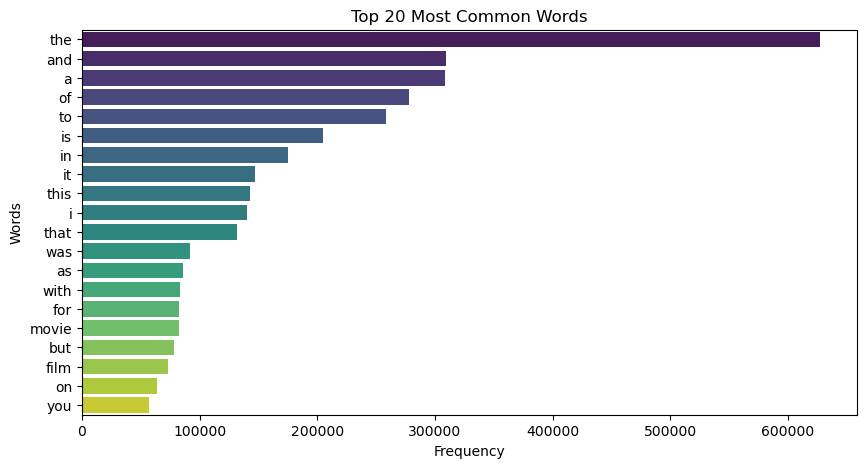

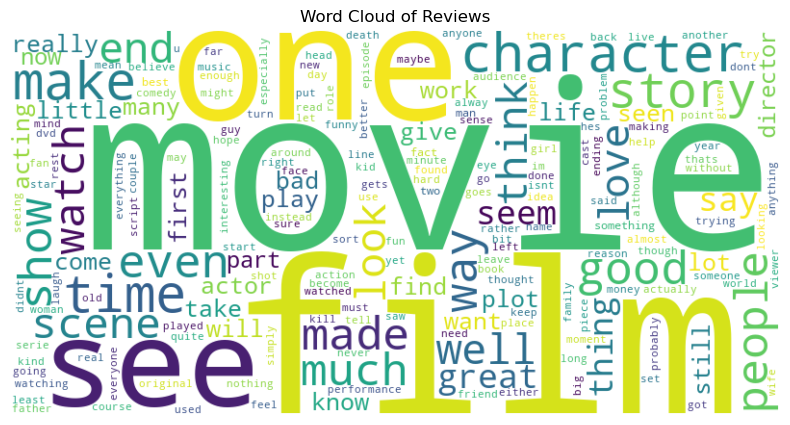

In [12]:
# Word frequency
word_counts = pd.Series(' '.join(df["cleaned_review"]).split()).value_counts()[:20]

# Bar chart
plt.figure(figsize=(10, 5))
sns.barplot(x=word_counts.values, y=word_counts.index, palette="viridis")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Common Words")
plt.show()

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_review']))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

# Sentiment Analysis with VADER

I would like to choose VADER in order to predic sentiment, in future I will create my own model but I would like to compare it with VADER

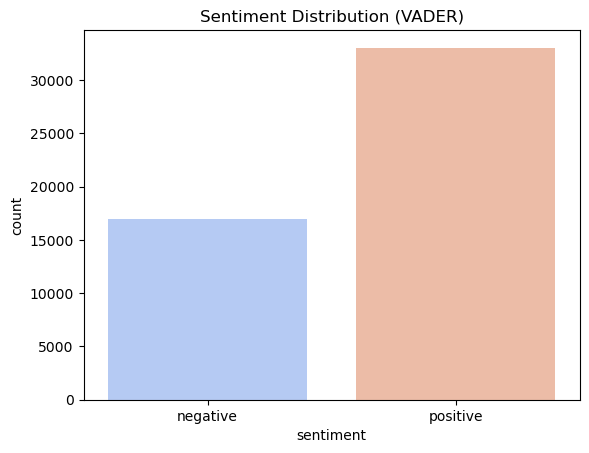

In [13]:
# Initialize VADER Sentiment Analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_sentiment(text):
    score = analyzer.polarity_scores(text)["compound"]
    return "positive" if score >= 0 else "negative"

# Apply sentiment analysis
df["sentiment"] = df["cleaned_review"].apply(get_sentiment)

# Display sentiment distribution
sns.countplot(data=df, x="sentiment", palette="coolwarm")
plt.title("Sentiment Distribution (VADER)")
plt.show()

# Custom Emotion Dictionary
Now I am going to create a custom dictionary. I want to classify reviews into 4 groups: excitement, anger, sadness and neutral.

In [14]:
# Custom dictionary with expanded words
emotion_dict = {
    "excitement": [
        "amazing", "fantastic", "awesome", "thrilling", "wonderful", "love", 
        "great", "exciting", "epic", "joyful", "incredible", "spectacular", "stunning", "superb"
    ],
    "anger": [
        "terrible", "horrible", "awful", "hate", "frustrating", "annoying", "worst", 
        "furious", "rage", "disgusting", "miserable", "pathetic", "disappointed"
    ],
    "sadness": [
        "sad", "disappointing", "heartbreaking", "boring", "unhappy", "depressing", 
        "mournful", "tragic", "tearful", "hopeless", "gloomy", "melancholy"
    ],
    "neutral": []  # If none of the words match, classify as neutral
}

def classify_emotion(text):
    words = text.lower().split()
    scores = {"excitement": 0, "anger": 0, "sadness": 0}
    
    for word in words:
        for emotion, keywords in emotion_dict.items():
            if word in keywords:
                scores[emotion] += 1  # Count occurrences
    
    # Assign the most dominant emotion, otherwise classify as "neutral"
    max_emotion = max(scores, key=scores.get)
    return max_emotion if scores[max_emotion] > 0 else "neutral"

# Apply classification to dataset
df["emotion_category"] = df["cleaned_review"].apply(classify_emotion)

# Display a sample of classified reviews
df[["review", "emotion_category"]].head()

,review,emotion_category
0,One of the other reviewers has mentioned that ...,neutral
1,A wonderful little production. <br /><br />The...,excitement
2,I thought this was a wonderful way to spend ti...,excitement
3,Basically there's a family where a little boy ...,neutral
4,"Petter Mattei's ""Love in the Time of Money"" is...",excitement


# Train ML Model to Predict Emotion Category
Now i am going to create a ML Model to predict emotion category

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df["cleaned_review"])
y = df["emotion_category"]  # Target variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Logistic Regression Model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

C:\Users\Sir Arktur\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9229
              precision    recall  f1-score   support

       anger       0.96      0.85      0.90      1835
  excitement       0.96      0.96      0.96      4299
     neutral       0.86      0.99      0.92      3370
     sadness       0.97      0.44      0.61       496

    accuracy                           0.92     10000
   macro avg       0.94      0.81      0.85     10000
weighted avg       0.93      0.92      0.92     10000



Model performs great on excitement and neutral emotions.
Sadness needs improvement — the model finds sadness when it predicts it, but it's not sensitive enough to catch all the sad examples.

# Compare ML Model with VADER

In [16]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate VADER sentiment score
def get_vader_sentiment(text):
    return analyzer.polarity_scores(text)["compound"]

# Apply function to dataset
df["vader_score"] = df["cleaned_review"].apply(get_vader_sentiment)

# Convert VADER sentiment score to emotion categories
def map_vader_to_emotion(score):
    if score > 0.5:
        return "excitement"
    elif score < -0.5:
        return "anger"
    else:
        return "neutral"

df["vader_sentiment"] = df["vader_score"].apply(map_vader_to_emotion)

# Display a sample
df[["review", "vader_score", "vader_sentiment"]].head()

,review,vader_score,vader_sentiment
0,One of the other reviewers has mentioned that ...,-0.9558,anger
1,A wonderful little production. <br /><br />The...,0.9657,excitement
2,I thought this was a wonderful way to spend ti...,0.9766,excitement
3,Basically there's a family where a little boy ...,-0.9117,anger
4,"Petter Mattei's ""Love in the Time of Money"" is...",0.9744,excitement


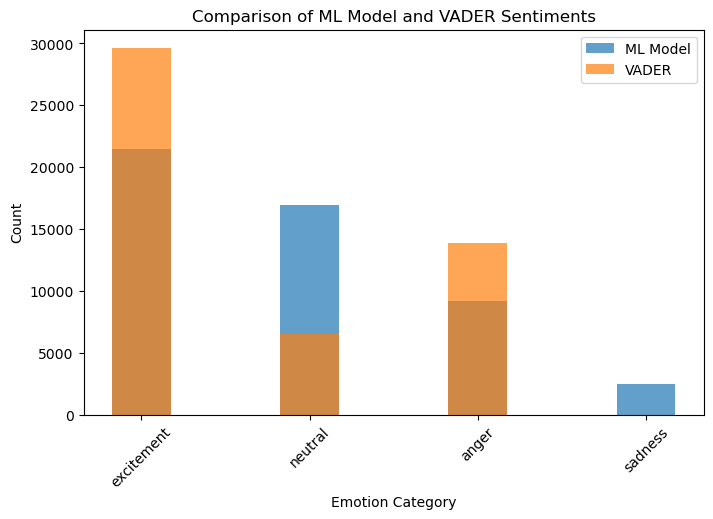

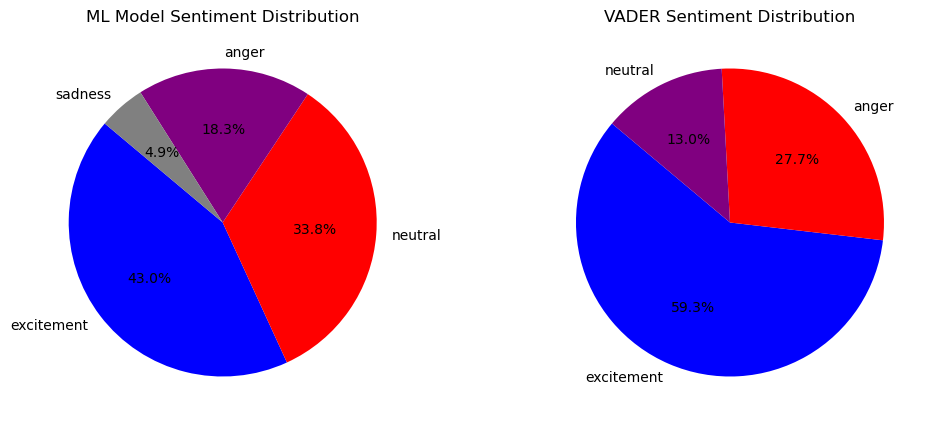

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Count sentiment labels
ml_counts = df["emotion_category"].value_counts()
vader_counts = df["vader_sentiment"].value_counts()

# Bar Chart
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.35

ax.bar(ml_counts.index, ml_counts.values, width=bar_width, label="ML Model", alpha=0.7)
ax.bar(vader_counts.index, vader_counts.values, width=bar_width, label="VADER", alpha=0.7)

ax.set_xlabel("Emotion Category")
ax.set_ylabel("Count")
ax.set_title("Comparison of ML Model and VADER Sentiments")
ax.legend()
plt.xticks(rotation=45)

plt.show()
# Create a confusion matrix
conf_matrix = confusion_matrix(df["emotion_category"], df["vader_sentiment"], labels=["excitement", "anger", "sadness", "neutral"])

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ML Model Pie Chart
axes[0].pie(ml_counts, labels=ml_counts.index, autopct="%1.1f%%", colors=["blue", "red", "purple", "gray"], startangle=140)
axes[0].set_title("ML Model Sentiment Distribution")

# VADER Pie Chart
axes[1].pie(vader_counts, labels=vader_counts.index, autopct="%1.1f%%", colors=["blue", "red", "purple", "gray"], startangle=140)
axes[1].set_title("VADER Sentiment Distribution")

plt.show()

As you can see, VADER sentiment shows absense of sadness, at the same time my model shows that it is hard to distinguish sentiments with 33.8% of neutral. 

# Subjectivity Analysis

I want to find out what is the subjectivity of those review and maybe check if anger/sadness reviews are more subjective

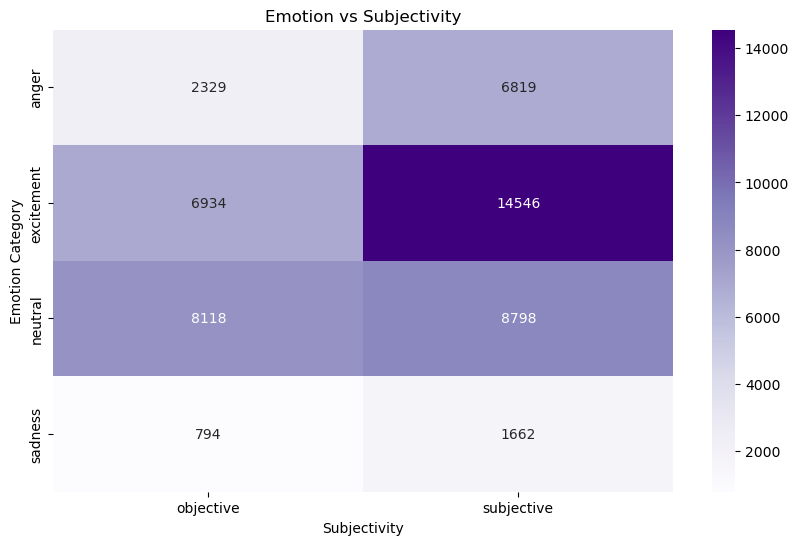

In [18]:
from textblob import TextBlob

# Function to calculate subjectivity
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Apply subjectivity to dataset
df["subjectivity_score"] = df["cleaned_review"].apply(get_subjectivity)

# Define subjectivity category
df["subjectivity_label"] = df["subjectivity_score"].apply(lambda x: "subjective" if x > 0.5 else "objective")

# Compare subjectivity with emotion
plt.figure(figsize=(10, 6))
sns.heatmap(pd.crosstab(df["emotion_category"], df["subjectivity_label"]), annot=True, cmap="Purples", fmt="d")
plt.xlabel("Subjectivity")
plt.ylabel("Emotion Category")
plt.title("Emotion vs Subjectivity")
plt.show()

Excitement is the most subjective emotion. We can suggest that excitement is typically expressed with personal opinions or feelings.
Neutral emotion balanced (8118 objective, 8798 subjective).

# Predict Emotion & Subjectivity for New Reviews

You can see that I have added new review for testing, in this case you can see that "the movie was incredibly thrilling" is considered as excitement sentiment with predicted subjectivity: subjective

In [19]:
def predict_emotion_and_subjectivity(review, model):
    review_cleaned = clean_text(review)
    
    # Predict emotion using trained ML model
    review_vectorized = vectorizer.transform([review_cleaned])
    emotion_prediction = model.predict(review_vectorized)[0]
    
    # Predict subjectivity
    subjectivity_score = get_subjectivity(review_cleaned)
    subjectivity_label = "subjective" if subjectivity_score > 0.5 else "objective"
    
    return emotion_prediction, subjectivity_label

# Test with a new review
new_review = "The movie was incredibly thrilling, with an amazing storyline and stunning visuals!"
emotion, subjectivity = predict_emotion_and_subjectivity(new_review, lr_model)

print(f"Predicted Emotion: {emotion}")
print(f"Predicted Subjectivity: {subjectivity}")
new_review

Predicted Emotion: excitement
Predicted Subjectivity: subjective


'The movie was incredibly thrilling, with an amazing storyline and stunning visuals!'